In [1]:
# %pip install --force-reinstall ../optpricerpy/dist/optpricerpy-0.1.0-cp39-cp39-manylinux_2_27_x86_64.whl

In [2]:
import pandas as pd
import xarray as xr
import pandera as pan
import optpricerpy
from optpricerpy.pricing_engine import (
    Measure,
    PricingEngine,
    ScenarioShift,
    RiskFactorFilter,
)
from datetime import date
import seaborn as sns

Let construct a small portfolio of option trades. 
 1. We first read a csv of trades into a `pandas` dataframe.
 2. Then we construct the `Portfolio` object. This python objects acts as a wrapper around a native portfolio struct defined in rust.
 3. We then load the option trades into the portfolio in one bulk operation.

In [3]:
option_trades_df = pd.read_csv("option_trades.csv")
portfolio = optpricerpy.portfolio.Portfolio()
portfolio.load_option_trades(option_trades_df)
option_trades_df

,ticker,size,strike,option_type,expiry
0,AAPL,3000,160,call,2022-02-01
1,AAPL,3500,130,put,2022-04-01
2,MSFT,500,400,call,2023-01-01
3,TSLA,400,1100,call,2022-01-22
4,TSLA,300,1300,call,2023-01-01
5,TSLA,600,800,put,2023-01-01


Note that we get input validation and the api checks that the structure of our dataframe conforms

In [4]:
try:
    portfolio.load_option_trades(option_trades_df.rename(columns={"strike": "stricke"}))
except pan.errors.SchemaError as e:
    print(e)

error in check_types decorator of function 'load_option_trades': column 'strike' not in dataframe
  ticker  size  stricke option_type      expiry
0   AAPL  3000      160        call  2022-02-01
1   AAPL  3500      130         put  2022-04-01
2   MSFT   500      400        call  2023-01-01
3   TSLA   400     1100        call  2022-01-22
4   TSLA   300     1300        call  2023-01-01


We initialize a `MarketData` object and bulk load data for the tickers

In [5]:
marketdata_df = pd.read_csv("marketdata.csv")
md = optpricerpy.pricing_engine.MarketData()
md.load_market_data(marketdata_df)
marketdata_df

,ticker,spot,vol
0,AAPL,157.0,0.30
1,MSFT,333.0,0.12
2,TSLA,1099.0,0.25


The `PricingEngine` is the main entry to the calculation engine

In [6]:
pricing_engine = PricingEngine()

We can extract the full position image from the `Portfolio`.

In [7]:
sector_map = {
    "AAPL": "Technology",
    "MSFT": "Technology",
    "TSLA": "Automotive",
}
# augment the dataset with sector
posdata = portfolio.position_image().assign(sector=lambda x: x.ticker.map(sector_map))
posdata

,ticker,strike,expiry,option_type,sector
trade_id,,,,,
AAPL20220201C160_0,AAPL,160.0,2022-02-01,call,Technology
AAPL20220401P130_1,AAPL,130.0,2022-04-01,put,Technology
MSFT20230101C400_2,MSFT,400.0,2023-01-01,call,Technology
TSLA20220122C1100_3,TSLA,1100.0,2022-01-22,call,Automotive
TSLA20230101C1300_4,TSLA,1300.0,2023-01-01,call,Automotive
TSLA20230101P800_5,TSLA,800.0,2023-01-01,put,Automotive


Here we issue our first pricing request. We call into the engine requesting to price the supplied `Portfolio` object per a given date and using the supplied `MarketData`. 

In [8]:
metric_df = (
    pricing_engine.price_portfolio(
        [Measure.EXPOSURE, Measure.PRICE], date(2021, 12, 1), portfolio, md
    )
    .unstack("measure")
    .droplevel(level=0, axis=1)
)
metric_df

measure,exposure,price
trade_id,,
AAPL20220201C160_0,5.353060e+06,6.404536
AAPL20220401P130_1,-6.007300e+06,1.714311
MSFT20230101C400_2,3.093627e+06,1.439806
TSLA20220122C1100_3,6.085244e+06,40.877058
TSLA20230101C1300_4,2.264812e+06,48.533762
TSLA20230101P800_5,-4.908262e+06,13.085494


Next we price the measure `exposure`, this time in a shifted context. We parameterize the calculation request with a volatility-shift

In [9]:
def _col_renamer(df):
    df.columns = [f"exposure_{c:.0%}" for c in df.columns]
    return df


vec_df = (
    pricing_engine.price_portfolio_ladder_scenario(
        [Measure.EXPOSURE],
        date(2021, 12, 1),
        portfolio,
        md,
        ScenarioShift(
            Measure.VOL,
            None,
            rel_shifts=[0.0, 0.0, 0.0, 0.0],
            abs_shifts=[-0.05, -0.01, 0.01, 0.05],
        ),
    )
    .set_index(["trade_id", "abs_shift"])
    .drop(columns=["measure", "rel_shift"])
    .unstack("abs_shift")
    .droplevel(level=0, axis=1)
    .pipe(_col_renamer)
)
vec_df.style.format(precision=0, thousands=" ")

,exposure_-5%,exposure_-1%,exposure_1%,exposure_5%
trade_id,,,,
AAPL20220201C160_0,6 459 952,5 541 820,5 177 259,4 580 227
AAPL20220401P130_1,-7 893 313,-6 315 898,-5 724 738,-4 800 202
MSFT20230101C400_2,7 338 929,3 522 425,2 753 435,1 899 763
TSLA20220122C1100_3,7 558 380,6 330 534,5 858 906,5 105 037
TSLA20230101C1300_4,2 963 856,2 376 058,2 163 962,1 840 388
TSLA20230101P800_5,-6 958 343,-5 227 244,-4 621 706,-3 720 336


Combine results to allow insights on a aggregated level

In [10]:
result_df = posdata.join(metric_df).join(vec_df)
result_df.style.format(precision=0, thousands=" ", formatter={"price": "{:0.2f}"})

,ticker,strike,expiry,option_type,sector,exposure,price,exposure_-5%,exposure_-1%,exposure_1%,exposure_5%
trade_id,,,,,,,,,,,
AAPL20220201C160_0,AAPL,160,2022-02-01 00:00:00,call,Technology,5 353 060,6.40,6 459 952,5 541 820,5 177 259,4 580 227
AAPL20220401P130_1,AAPL,130,2022-04-01 00:00:00,put,Technology,-6 007 300,1.71,-7 893 313,-6 315 898,-5 724 738,-4 800 202
MSFT20230101C400_2,MSFT,400,2023-01-01 00:00:00,call,Technology,3 093 627,1.44,7 338 929,3 522 425,2 753 435,1 899 763
TSLA20220122C1100_3,TSLA,1 100,2022-01-22 00:00:00,call,Automotive,6 085 244,40.88,7 558 380,6 330 534,5 858 906,5 105 037
TSLA20230101C1300_4,TSLA,1 300,2023-01-01 00:00:00,call,Automotive,2 264 812,48.53,2 963 856,2 376 058,2 163 962,1 840 388
TSLA20230101P800_5,TSLA,800,2023-01-01 00:00:00,put,Automotive,-4 908 262,13.09,-6 958 343,-5 227 244,-4 621 706,-3 720 336


In [11]:
exposure_cols = [
    "exposure_-5%",
    "exposure_-1%",
    "exposure",
    "exposure_1%",
    "exposure_5%",
]

Here we want to see the the portfolio sensitivity broken by underlying ticker

In [12]:
by_ticker = result_df.pivot_table(
    index=["ticker"],
    values=["exposure", "exposure_-5%", "exposure_-1%", "exposure_1%", "exposure_5%"],
    aggfunc="sum",
    margins=True,
)
by_ticker[exposure_cols].style.format(precision=0, thousands=" ")

,exposure_-5%,exposure_-1%,exposure,exposure_1%,exposure_5%
ticker,,,,,
AAPL,-1 433 361,-774 078,-654 240,-547 479,-219 975
MSFT,7 338 929,3 522 425,3 093 627,2 753 435,1 899 763
TSLA,3 563 892,3 479 349,3 441 794,3 401 162,3 225 089
All,9 469 460,6 227 696,5 881 181,5 607 118,4 904 876


or by sector

In [13]:
by_sector = result_df.pivot_table(
    index=["sector"],
    values=["exposure", "exposure_-5%", "exposure_-1%", "exposure_1%", "exposure_5%"],
    aggfunc="sum",
    margins=True,
)
by_sector[exposure_cols].style.format(precision=0, thousands=" ")

,exposure_-5%,exposure_-1%,exposure,exposure_1%,exposure_5%
sector,,,,,
Automotive,3 563 892,3 479 349,3 441 794,3 401 162,3 225 089
Technology,5 905 568,2 748 347,2 439 387,2 205 956,1 679 788
All,9 469 460,6 227 696,5 881 181,5 607 118,4 904 876


When we apply more advanced scenarios in more dimensions than 1 it is no longer practical to use a regular dataframe representation. The engine returns a more appropriate `xarray.Dataset` object (which can be thought of as a higher dimensional dataframe). 

In [14]:
arr = (
    pricing_engine.price_portfolio_2d_matrix_scenario(
        [Measure.EXPOSURE],
        date(2021, 12, 1),
        portfolio,
        md,
        x_shift=ScenarioShift(
            Measure.PRICE,
            RiskFactorFilter.EQUITY,
            rel_shifts=[-0.05, -0.01, 0, 0.01, 0.05],
            abs_shifts=[0.0, 0.0, 0.0, 0.0, 0.0],
        ),
        y_shift=ScenarioShift(
            Measure.VOL,
            None,
            rel_shifts=[-0.05, -0.01, 0, 0.01, 0.05],
            abs_shifts=[0.0, 0.0, 0.0, 0.0, 0.0],
        ),
    )
    .merge(xr.Dataset(posdata))
    .assign_coords(
        {
            "shift_price": [-0.05, -0.01, 0, 0.01, 0.05],
            "shift_vol": [-0.05, -0.01, 0, 0.01, 0.05],
        }
    )
)
arr

<xarray.Dataset>
Dimensions:      (trade_id: 6, shift_price: 5, shift_vol: 5)
Coordinates:
  * trade_id     (trade_id) <U19 'AAPL20220201C160_0' ... 'TSLA20230101P800_5'
  * shift_price  (shift_price) float64 -0.05 -0.01 0.0 0.01 0.05
  * shift_vol    (shift_vol) float64 -0.05 -0.01 0.0 0.01 0.05
Data variables:
    exposure     (trade_id, shift_price, shift_vol) float64 6.418e+06 ... -5....
    ticker       (trade_id) object 'AAPL' 'AAPL' 'MSFT' 'TSLA' 'TSLA' 'TSLA'
    strike       (trade_id) float64 160.0 130.0 400.0 1.1e+03 1.3e+03 800.0
    expiry       (trade_id) datetime64[ns] 2022-02-01 2022-04-01 ... 2023-01-01
    option_type  (trade_id) object 'call' 'put' 'call' 'call' 'call' 'put'
    sector       (trade_id) object 'Technology' 'Technology' ... 'Automotive'

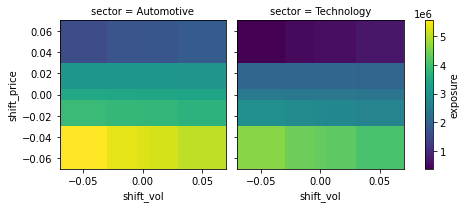

In [15]:
arr.groupby("sector").sum()["exposure"].plot(col="sector")

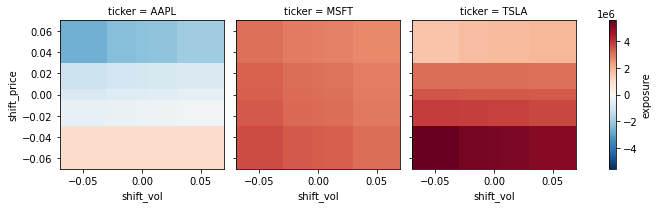

In [16]:
arr.groupby("ticker").sum()["exposure"].plot(col="ticker")

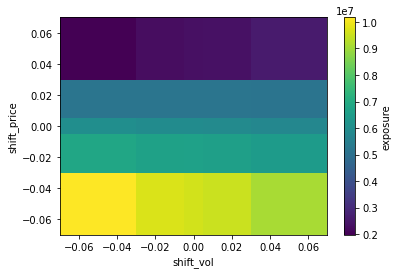

In [17]:
arr["exposure"].sum("trade_id").plot()